### Importing necessary libraries

In [ ]:
import warnings
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import cv2
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
import time
import datetime
warnings.filterwarnings('ignore')

FIRE_PATH = "./data/FIRE/"
ACC_PATH = "./data/ACCIDENT/"
ROB_PATH = "./data/ROBBERY/"
NORMAL_PATH = "./data/train/"

CLASSES = ["Normal", "Fire", "Accident", "Robbing"]

# Define the training and testing sets' split size
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

# Initialize the model parameters (learning rate, batch size, and number of epochs)
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 3

### Data Collection and Preprocessing

In [ ]:
def load_dataset(datasetPath):
    # grab the paths to all images in our dataset directory, then
    # initialize our lists of images
    imagePaths = list(paths.list_images(datasetPath))
    data = []
    # loop over the image paths
    for imagePath in imagePaths:
        # load the image and resize it to be a fixed 128x128 pixels,
        # ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.resize(image, (128, 128))
        # add the image to the data lists
        data.append(image)
        # return the data list as a NumPy array
    return np.array(data, dtype="float32")

print("[INFO] loading normal data...")
normalData = load_dataset(NORMAL_PATH)
print("[INFO] loading fire data...")
fireData = load_dataset(FIRE_PATH)
print("[INFO] loading accident data...")
accidentData = load_dataset(ACC_PATH)
print("[INFO] loading robbery data...")
robberyData = load_dataset(ROB_PATH)

[INFO] loading normal data...
[INFO] loading fire data...
[INFO] loading accident data...
[INFO] loading robbery data...


<Figure size 640x480 with 0 Axes>

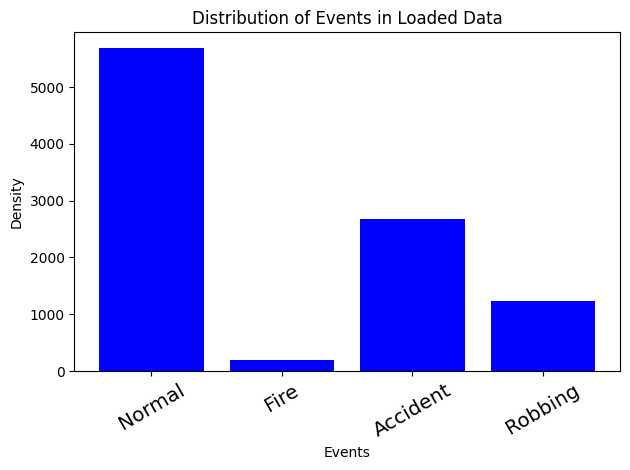

<Figure size 640x480 with 0 Axes>

In [ ]:
label = CLASSES
file_count = [normalData.shape[0],fireData.shape[0],accidentData.shape[0],robberyData.shape[0]]
index=np.arange(len(label))
plt.bar(index,file_count, color="blue")
plt.xlabel('Events')
plt.ylabel('Density')
plt.xticks(index,label,rotation=30,fontsize = 'x-large')
plt.title('Distribution of Events in Loaded Data')
plt.tight_layout()
plt.savefig('train_test_data_distribution.png', format='png', dpi=1000)
# plt.style.use("ggplot")
plt.figure()


In [ ]:
normalData.shape, fireData.shape, accidentData.shape, robberyData.shape

((5681, 128, 128, 3),
 (192, 128, 128, 3),
 (2672, 128, 128, 3),
 (1241, 128, 128, 3))

In [ ]:
(192+2672+1241) / (5681+192+2672+1241)

0.41947680359697526

### Exploratory Data Analysis

[INFO] Label created for all data...
[INFO] stacking data...




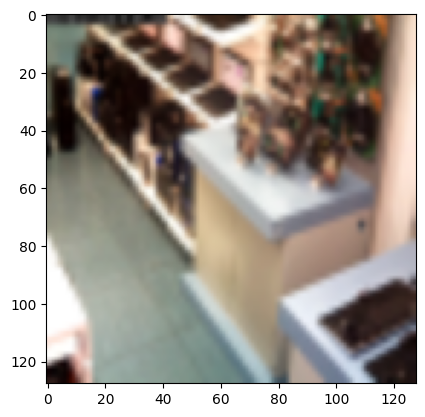

In [ ]:
# construct the class labels for the data
normalLabels = np.zeros((normalData.shape[0],))
fireLabels = np.ones((fireData.shape[0], ))
accidentLabels = np.full(accidentData.shape[0],2)
robberyLabels = np.full(robberyData.shape[0],3)
print("[INFO] Label created for all data...")
labels = np.hstack([normalLabels, fireLabels, accidentLabels, robberyLabels])
# print(labels)
# print(len(normalLabels), len(fireLabels), len(accidentLabels), len(robberyLabels))
labels = labels.astype(int)
# stack the fire data with the non-fire data
print("[INFO] stacking data...")
data = np.vstack([normalData, fireData, accidentData, robberyData])
# print(data)
data /= 255    #scale the data to the range [0, 1]
pic = data[1101]
plt.grid(False)
plt.imshow(pic)
model = load_model("./models/anomaly_detection.h5")

In [ ]:
data.shape

(9786, 128, 128, 3)

In [ ]:
labels.shape

(9786,)

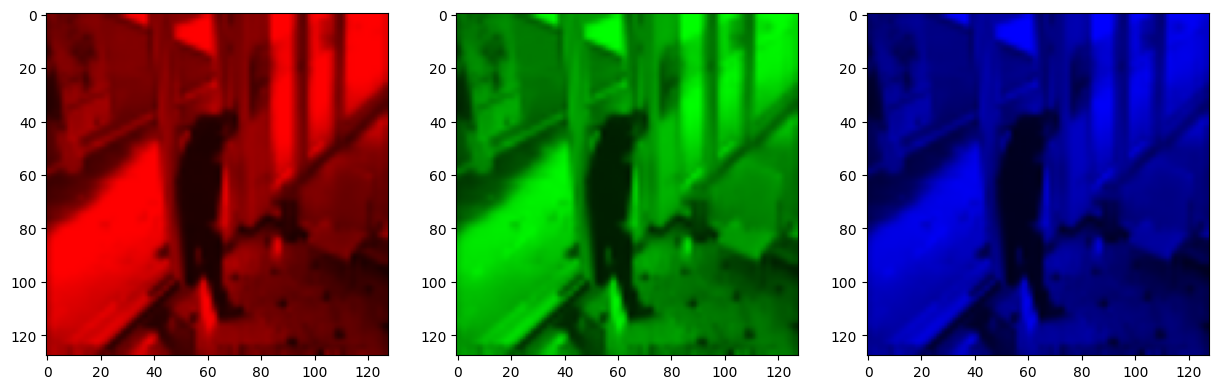

In [ ]:
# display each channel
pic = data[9500]
fig, ax = plt.subplots(nrows = 1, ncols=3, figsize=(15,5))
for c, ax in zip(range(3), ax):
    # create zero matrix
    split_img = np.zeros(pic.shape, dtype="float32") # 'dtype' by default: 'numpy.float64'
    # assing each channel
    split_img[ :, :, c] = pic[ :, :, c]
    ax.grid(False)
    # display each channel
    ax.imshow(split_img)
plt.show()

In [ ]:
# perform one-hot encoding on the labels and account for skew in the labeled data
# labels = to_categorical(labels, num_classes=4)
classTotals = labels.sum(axis = 0)
classWeight = classTotals.max() / classTotals
labels

array([0, 0, 0, ..., 3, 3, 3])

### TRAIN - TEST SPLIT

In [ ]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size = 0.4194, random_state = 42)



trainX.shape

(5681, 128, 128, 3)

In [ ]:
trainY.shape

(5681,)

In [ ]:
testX.shape

(4105, 128, 128, 3)

In [ ]:
testY.shape

(4105,)

In [ ]:
labels

array([0, 0, 0, ..., 3, 3, 3])

### Model Creation

In [ ]:
width, height, depth, classes = 128, 128, 3, 4
# initialize the model along with the input shape to be
# "channels last" and the channels dimension itself
model = Sequential()
img_shape = (height, width, depth)
chanDim = -1
# CONV => RELU => POOL
model.add(SeparableConv2D(16, (7, 7), padding="same",input_shape=img_shape, activation="relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# CONV => RELU => POOL
model.add(SeparableConv2D(32, (3, 3), padding="same",activation="relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# (CONV => RELU) * 2 => POOL
model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
#model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(SeparableConv2D(64, (3, 3), padding="same",activation="relu"))
#model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
# first set of FC => RELU layers
model.add(Flatten())
model.add(Dense(128))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# second set of FC => RELU layers
model.add(Dense(128, activation="relu"))
# model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
# softmax classifier
model.add(Dense(classes))
model.add(Activation("softmax"))
# return the constructed network architecture



### Optimize the model parameters (weights and biases)

In [ ]:
# initialize the optimizer and model
opt = SGD(learning_rate= INIT_LR, momentum = 0.9)
# opt_2 = RMSprop()
model.compile(loss = "sparse_categorical_crossentropy", optimizer = opt, metrics =["accuracy"], run_eagerly=True)
print("[INFO] compiling model...")

[INFO] compiling model...


In [ ]:
#Utilize callback to store the weights of the best model
checkpointer = ModelCheckpoint(filepath="./data/best_weights_act_DWS.hdf5",
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_best_only=True)


NUM_EPOCHS = 50
# train the network
t_start = datetime.datetime.now()
history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=NUM_EPOCHS, callbacks=checkpointer)
t_end= datetime.datetime.now()
timeTaken = t_end - t_start
print("Time taken for training(ms):",int(timeTaken.total_seconds()*1000))




Ttime = timeTaken
print("Time for 100 epochs:",
      Ttime.seconds//3600, "hours",
      (Ttime.seconds//60)%60,"minutes")


Epoch 1/50

178/178 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8961
Epoch 1: val_accuracy improved from -inf to 0.81194, saving model to ./data\best_weights_act_DWS.hdf5
178/178 [==============================] - 42s 230ms/step - loss: 0.3210 - accuracy: 0.8961 - val_loss: 0.6312 - val_accuracy: 0.8119
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9798
Epoch 2: val_accuracy improved from 0.81194 to 0.99586, saving model to ./data\best_weights_act_DWS.hdf5
178/178 [==============================] - 39s 222ms/step - loss: 0.0694 - accuracy: 0.9798 - val_loss: 0.0156 - val_accuracy: 0.9959
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9873
Epoch 3: val_accuracy did not improve from 0.99586
178/178 [==============================] - 39s 219ms/step - loss: 0.0478 - accuracy: 0.9873 - val_loss: 0.0223 - val_accuracy: 0.9956
Epoch 4/50
178/178 [==============================]

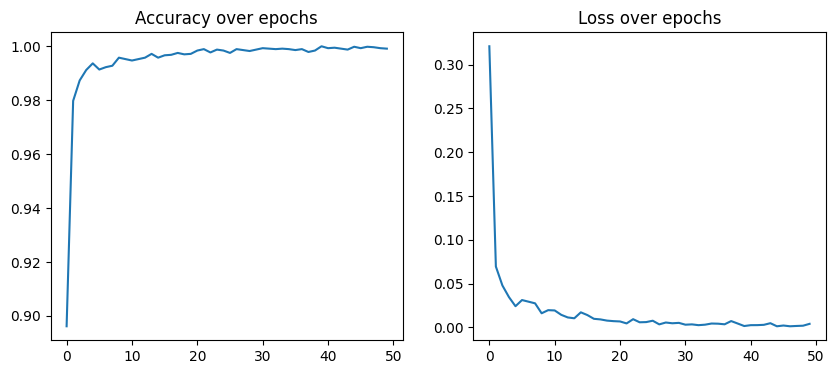

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history.history["accuracy"])
ax[0].set_title("Accuracy over epochs")
ax[1].plot(history.history["loss"])
ax[1].set_title("Loss over epochs")
plt.show()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separabl  (None, 128, 128, 16)      211       
 eConv2D)                                                        
                                                                 
 batch_normalization (Batch  (None, 128, 128, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 separable_conv2d_1 (Separa  (None, 64, 64, 32)        688       
 bleConv2D)                                                      
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 32)        1

### Save the model

In [21]:
# Load the classifier with the weights of the best model
# model.load_weights('./data/best_weights_act_DWS.hdf5')

# Saving the complete model
model.save('./models/anomaly_detection.h5')

### Testing and Evaluation

In [22]:
loss,acc = model.evaluate(testX, testY, verbose = 1)
print(f'Accuracy of the model is %f' %(acc * 100))

# Evaluate the network and display the classification report
predictions = model.predict(testX, batch_size = BATCH_SIZE)
print("Classification Report:")
print(classification_report(testY, predictions.argmax(axis = 1), target_names = CLASSES))

129/129 [==============================] - 10s 76ms/step - loss: 0.0587 - accuracy: 0.9985
Accuracy of the model is 99.853837
65/65 [==============================] - 9s 129ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2438
        Fire       1.00      0.99      0.99        71
    Accident       1.00      1.00      1.00      1086
     Robbing       1.00      1.00      1.00       510

    accuracy                           1.00      4105
   macro avg       1.00      1.00      1.00      4105
weighted avg       1.00      1.00      1.00      4105



In [1]:
con_mat = confusion_matrix(testY, predictions.argmax(axis = 1))
print(con_mat)
sns.heatmap(con_mat, annot=True, cmap=plt.cm.Blues,fmt="d")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

NameError: name 'confusion_matrix' is not defined

In [1]:
CLASSES = ["Normal", "Fire", "Accident", "Robbing"]
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
model = load_model('./models/anomaly_detection.h5')
def predict(path):
    # Load video
    output_notebook()

    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA) # because Bokeh expects a RGBA image
    frame = cv2.flip(frame, 0) # because Bokeh flips vertically
    width = frame.shape[1]
    height = frame.shape[0]
    p = figure(x_range=(0,width), y_range=(0,height), output_backend="webgl", width=700, height=400)
    myImage = p.image_rgba(image=[frame], x=0, y=0, dw=width, dh=height)
    label = ""
    show(p, notebook_handle = True)

    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret:
            img = frame
            img = cv2.resize(img,(128, 128),interpolation=cv2.INTER_AREA)
            img = img.astype("float64") / 255.0
            plt.imshow(img)
            preds = model.predict(np.expand_dims(img, axis=0))[0]
            j = np.argmax(preds)
            label = CLASSES[j]
            cv2.putText(frame, label, (35, 50), cv2.FONT_HERSHEY_SIMPLEX,1.25, (0, 255, 0), 5)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            frame = cv2.flip(frame, 0)
            myImage.data_source.data['image'] = [frame]
            push_notebook()
            if cv2.waitKey(1) & 0xFF == ord('q'): # press q to quit
                break
        else:
            break
        #time.sleep(0.2)
    cap.release()
    print('Detected Activity:', label)





predict(input('Video file path:'))


Loading BokehJS ...

1/1 [==============================] - ETA: 0s